# Simulasi Monte Carlo untuk pergerakan saham

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# Proyeksi pergerakan saham secara historis dan aktual

In [2]:
yADRO = yf.Ticker("ADRO.JK")
# get historical market data
hist = yADRO.history(start="2021-06-30", end="2022-06-30")
actual = yADRO.history(start="2022-6-30", end="2022-12-30")
semua = yADRO.history(start="2021-06-30", end="2022-12-30")
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243 entries, 2021-06-30 00:00:00+07:00 to 2022-06-29 00:00:00+07:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          243 non-null    float64
 1   High          243 non-null    float64
 2   Low           243 non-null    float64
 3   Close         243 non-null    float64
 4   Volume        243 non-null    int64  
 5   Dividends     243 non-null    float64
 6   Stock Splits  243 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 15.2 KB


[]

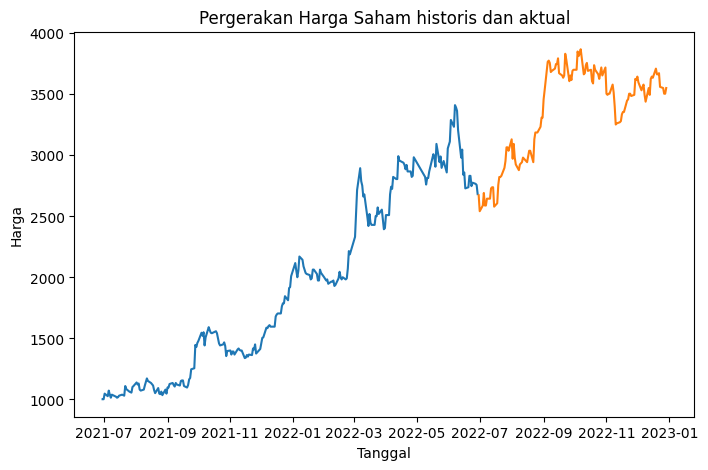

In [3]:
fig,ax = plt.subplots(1, figsize=(8,5))
ax.plot(hist['Close'], label = "close")
ax.plot(actual['Close'], label = "actual")
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.title("Pergerakan Harga Saham historis dan aktual")
ax.plot()

# Perhitungan probabilitas empiris

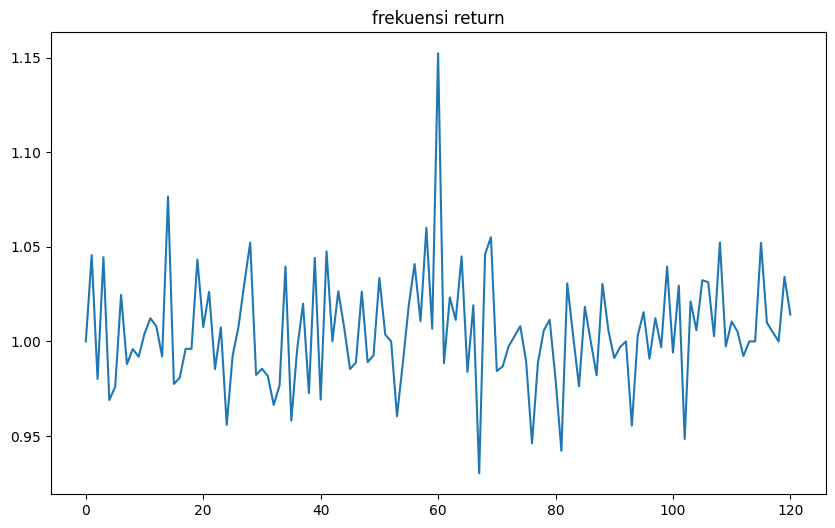

mean, std up 1.0261629039112417 0.023977897956768978
mean, std down 0.9832288058749141 0.0161068667028786
u,d,p= 1.0231728577499568 0.980598030325881 0.5785123966942148
variansi log saham($sigma^2t$)= 0.16450015820976785
Date
2021-06-30 00:00:00+07:00    1.000000
2021-07-01 00:00:00+07:00    1.045643
2021-07-02 00:00:00+07:00    0.980159
2021-07-05 00:00:00+07:00    1.044534
2021-07-06 00:00:00+07:00    0.968992
                               ...   
2022-06-23 00:00:00+07:00    1.010204
2022-06-24 00:00:00+07:00    0.996633
2022-06-27 00:00:00+07:00    0.996622
2022-06-28 00:00:00+07:00    0.972881
2022-06-29 00:00:00+07:00    0.000000
Name: return, Length: 243, dtype: float64


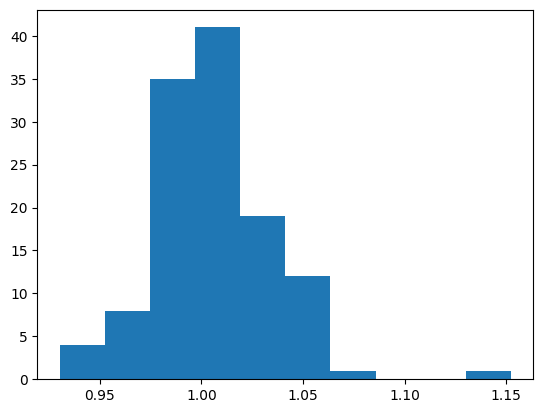

In [4]:
# estimasi parameter metode empiris 
hist['return'] = [hist.Close[i]/hist.Close[i-1] for i in range(1,len(hist))]+[0]#assign ke tabel return probabilitas return 
ret = np.array(hist['return'][0:int(len(hist)/2)])#pembuatan array return 
fig,ax = plt.subplots(1,figsize=(10,6))
ax.plot(ret)
plt.title("frekuensi return")
plt.show()#plotting frekueni return 
print('mean, std up', np.mean(ret[ret>1]), np.std(ret[ret>1]))#output rata2 nilai up, standar deviasi dari frekuensi return up
print('mean, std down',np.mean(ret[ret<=1]), np.std(ret[ret<=1]))#output rata2 nilai down, standar deviasi dari frekuensi return down

plt.hist(ret)#plotting return

up= np.mean(ret[ret>=1]) # estimasi nilai u empiris
dwn = np.mean(ret[ret<1])# estimasi nilai d emspiris
p_empi = len(ret[ret>=1])/len(ret)#frekuensi fi > 1/banyak dikritisasi
avret = np.mean(ret)#average return 
print('u,d,p=', up,dwn,p_empi)

# estimasi Model CRR sigma
logS= np.log(np.array([hist.Close[i] for i in range(0,int(len(hist)/2))]))#logaritma harga saham
print('variansi log saham($sigma^2t$)=', np.std(logS))#variansi logaritma harga saham
sig = np.sqrt(np.std(logS)/1)# volatilitas harga saham

print(hist['return'])

# Proyeksi tabel binomial dari pergerakan harga saham 

In [5]:
import math
# Estimasi nilai sigma dari log(S)
hist['logs'] = [np.log(k) for k in hist['Close']]
logs = np.array(hist['logs'])[0:int(len(hist)/2)+1] 
varLogs=np.std(logs)**2 #\sigma^2t
sigEst= np.sqrt(varLogs/1)
print(len(hist['logs'][int(len(hist)/2)+1:-1]))

120


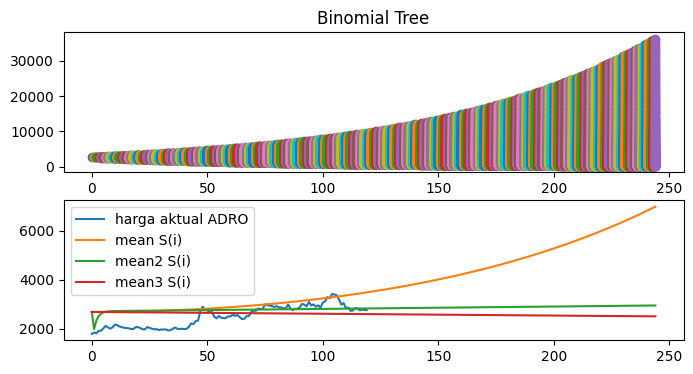

In [6]:
# Membuat pohon Binomial Saham
So = hist.Close[-1]
sig = sigEst
r = 0.055 # suku bunga bank Indonesia
N = 244 # hari perdagangan tahunan
dt = 1/N
u=np.exp(sig*np.sqrt(dt))
d=1/u
p=(np.exp(-r*dt)-d)/(u-d)

fig,ax = plt.subplots(2,figsize=(8,4))
price = np.zeros((N+1,N+1), float)
mean_si = np.zeros((N+1), float)
mean2_si = np.zeros((N+1), float)
mean3_si = np.zeros((N+1), float)
mean_si[0] = So
mean2_si[0] = So
mean3_si[0] = So
price[0,N] = So
ax[0].scatter(0, price[0,N])
ax[1].plot(range(len(hist.Close[int(len(hist)/2)+1:-1])), hist.Close[int(len(hist)/2)+1:-1], label='harga aktual ADRO')
for i in range(1,N+1): # time step 
  for j in reversed(range(i+1)): # jumlah kenaikan
    price[j,i] = So*u**(j)*d**(i-j)
  ax[0].scatter([i for k in range(len(price[0:i+1,i]))], price[0:i+1,i])
  mean_si[i] = np.mean(price[0:i+1,i])
  prob = np.array([math.comb(i+1, i+1-k)*p**(i+1-k)*(1-p)**k for k in range(i+1)])
  # print(prob.shape,price[0:i+1,i].shape )
  mean2_si[i] = np.sum(price[0:i+1,i]*prob) 
  mean3_si[i] = So*u**(i*p)*d**(i-i*p)
    # print(price[j,i])
    # print(j)
ax[0].set_title("Binomial Tree")
ax[1].plot(mean_si, label='mean S(i)')
ax[1].plot(mean2_si, label='mean2 S(i)')
ax[1].plot(mean3_si, label='mean3 S(i)')
plt.legend()

# Proyeksi perbandingan harga saham historis, aktual dan prediksi menggunakan metode CRR

In [7]:
# MOnte carlo simulation per time steps (Bernouli event for every time step)
so=hist.Close[-1]
T=1
N=130
dt=T/N
r = 0.055 # suku bunagn bank Indonesia
sig = 0.15
u=np.exp(sig*np.sqrt(dt))
d=1/u
p=(np.exp(-r*dt)-d)/(u-d)
M=200
smt = [[]]
for k in range(M):
  s=so
  sv=[s]
  for i in range(N):
    x=np.random.binomial(i,p)
    s=so*u**(x)*d**(i-x)
    sv=sv+[s]
  smt =smt+[sv] 

smt=[k for k in smt[1:][:]]  

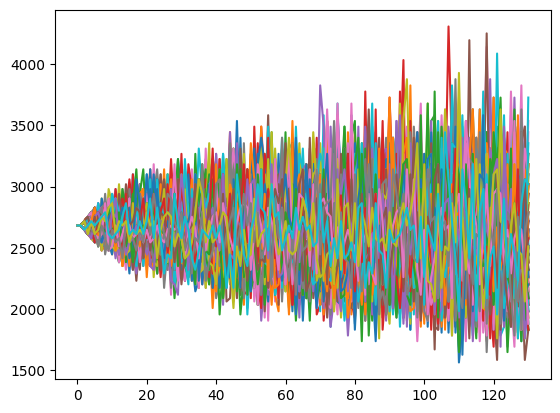

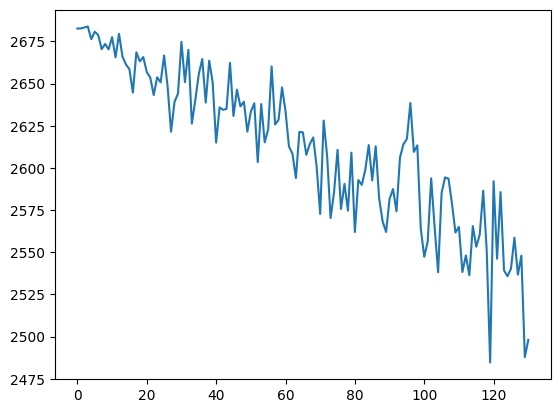

In [8]:
[plt.plot(k) for k in smt]
plt.show()
## Average path of stock prices
smean=np.mean(np.array(smt), axis=0)
plt.plot(smean)

In [37]:
#perhitungan error metode CRR
yADRO = yf.Ticker("ADRO.JK")

actual_ccr = yADRO.history(start = '2022-07-01', end = '2022-12-31')
crr = pd.Series(smean[1:], index=actual_ccr.index)

actual_ccr = actual_ccr.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)

actual_ccr['CRR'] = crr

actual_ccr['Selisih'] = actual_ccr['Close'] - actual_ccr['CRR']
actual_ccr['Kuadrat'] = actual_empiris['Selisih'] ** 2
actual_ccr['Absolute percentage error'] = abs(actual_ccr['Selisih'] / actual_ccr['Close'] * 100)

mse = actual_ccr['Kuadrat'].sum() / len(actual_ccr)
mape = actual_ccr['Absolute percentage error'].sum() / len(actual_ccr)

print('MSE CRR =', mse)
print('MAPE CRR =',mape)

MSE CRR = 537334.5369939327
MAPE CRR = 21.89343574899189


[]

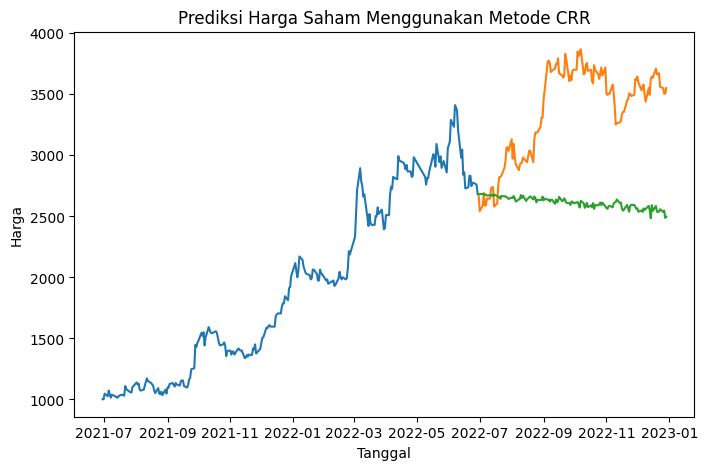

In [10]:
fig,ax = plt.subplots(1, figsize=(8,5))
ax.plot(hist['Close'], label = "close")
plt.xlabel('Tanggal')
plt.ylabel('Harga')
ax.plot(actual['Close'], label = "actual")
plt.plot(pd.Series(smean[1:], index=actual.index), label='prediksi')
plt.title("Prediksi Harga Saham Menggunakan Metode CRR")
ax.plot()

In [11]:
so = hist.Close[-1]
T = 1
N = 130
dt = T/N
r = 0.055
sig = sigEst
M = 200
smt = []

for k in range(M):
    s = so
    sv = [s]
    for i in range(1, N):
        x = np.random.binomial(i,p_empi)
        s = so*np.power(up, x) * np.power(dwn, i - x)
        sv = sv + [s]
    smt = smt + [sv]

smt = [k for k in smt[1:][:]]
averages = [np.mean(x) * 2 for x in smt]
avg = np.mean(averages)
std = np.std(averages)
confidence_interval = [avg - 1.96 * std, avg + 1.96 * std]

# Proyeksi perbandingan harga saham historis, aktual dan prediksi menggunakan metode empiris

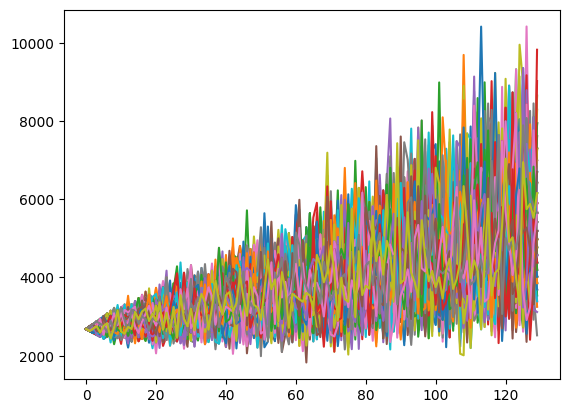

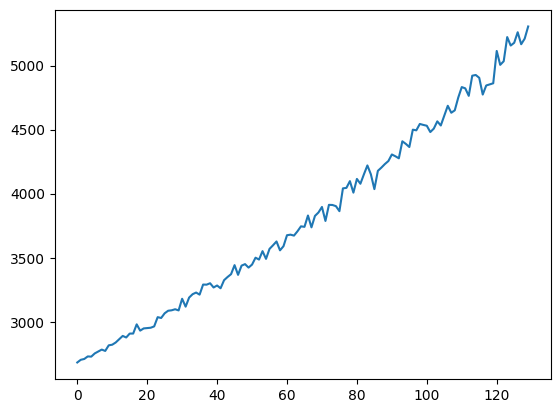

In [12]:
[plt.plot(k) for k in smt]
plt.show()
emean = np.mean(np.array(smt), axis = 0)
plt.plot(emean)

In [38]:
#perhitungan error metode pendekatan empiris
yADRO = yf.Ticker("ADRO.JK")

actual_empiris = yADRO.history(start = '2022-07-01', end = '2022-12-31')
empiris = pd.Series(emean, index=actual_empiris.index)

#drop coloums
actual_empiris = actual_empiris.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)

#add empiris
actual_empiris['Empiris'] = empiris

actual_empiris['Selisih'] = actual_empiris['Close'] - actual_empiris['Empiris']
actual_empiris['Kuadrat'] = actual_empiris['Selisih'] ** 2
actual_empiris['Absolute percentage error'] = abs(actual_empiris['Selisih'] / actual_empiris['Close'] * 100)

mse = actual_empiris['Kuadrat'].sum() / len(actual_empiris)
mape = actual_empiris['Absolute percentage error'].sum() / len(actual_empiris)

print('MSE empiris=', mse)
print('MAPE empiris=', mape)

MSE empiris= 537334.5369939327
MAPE empiris= 14.772572253747251


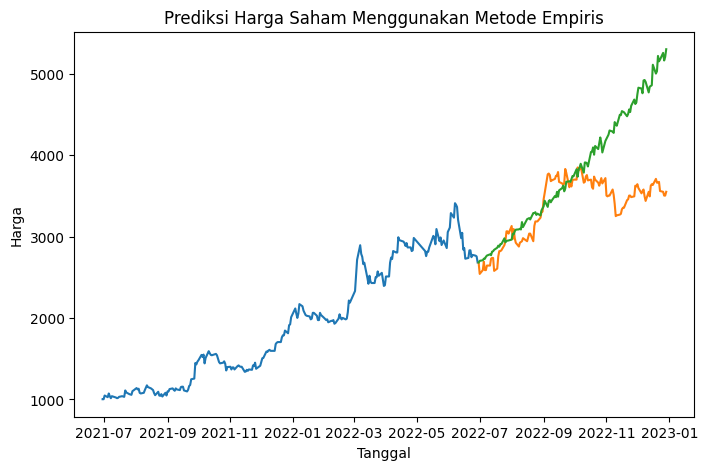

In [31]:
fig, ax = plt.subplots(1, figsize = (8,5))
ax.plot(hist['Close'])
plt.xlabel('Tanggal')
ax.plot(actual['Close'])
plt.ylabel('Harga')
plt.title("Prediksi Harga Saham Menggunakan Metode Empiris")
plt.plot(pd.Series(emean, index = actual.index), label = 'prediksi')

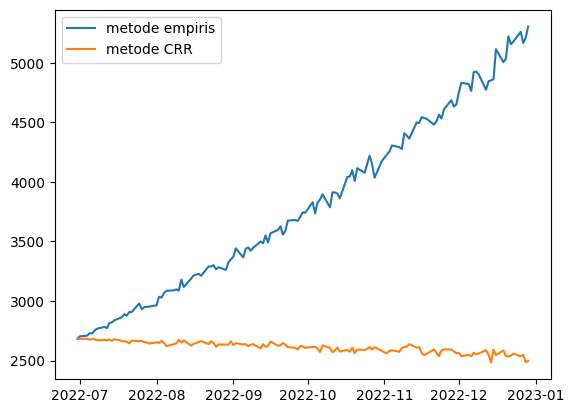

In [32]:
plt.plot(pd.Series(emean, index = actual.index), label = 'metode empiris')
plt.plot(pd.Series(smean[1:], index=actual.index), label='metode CRR')
plt.legend()
plt.show()

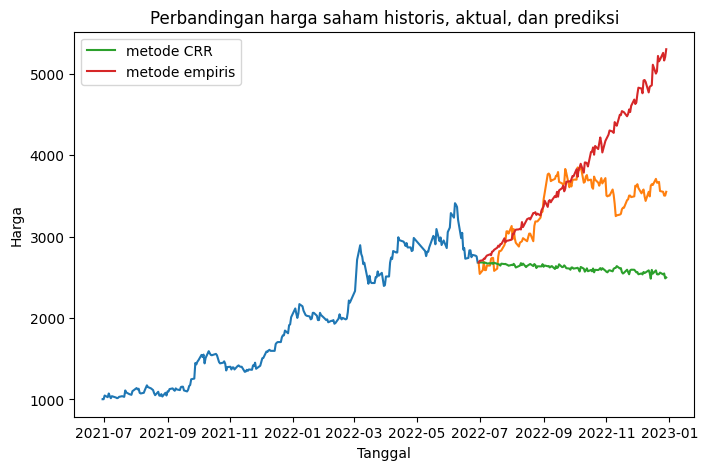

In [33]:
fig, ax = plt.subplots(1, figsize = (8,5))
ax.plot(hist['Close'])
plt.xlabel('Tanggal')
ax.plot(actual['Close'])
plt.ylabel('Harga')
plt.title("Perbandingan harga saham historis, aktual, dan prediksi")
plt.plot(pd.Series(smean[1:], index=actual.index), label='metode CRR')
plt.plot(pd.Series(emean, index = actual.index), label = 'metode empiris')
plt.legend()
plt.show()